/jet/home/nasch/.conda/envs/base_noah/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/jet/home/nasch/.conda/envs/base_noah/lib/python3.9/site-packages/cartopy/mpl/style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


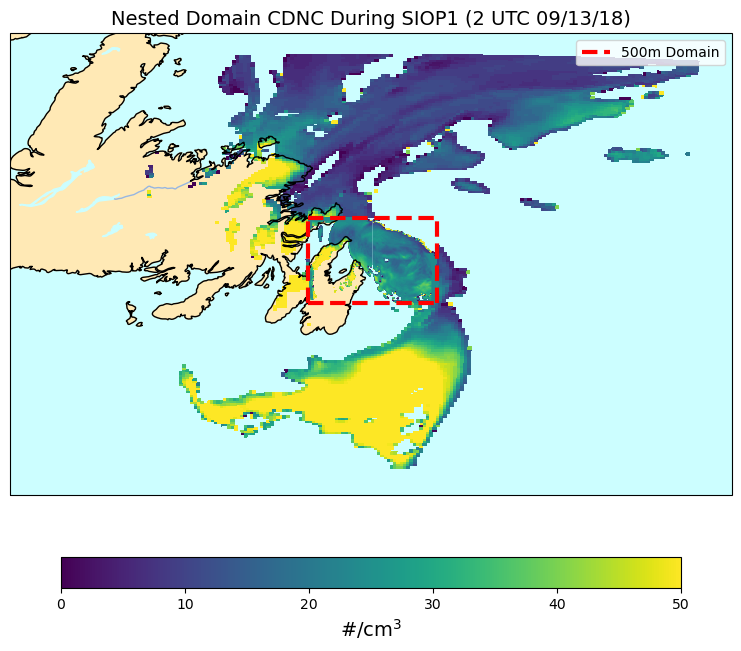

In [3]:
import matplotlib.pyplot as plt
import iris.plot as iplt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import iris


time = 13
level = 0
# Load data
high_res_drop = iris.load_cube('/ocean/projects/atm200005p/nasch/CFOG/rose_runs/w_min_0.001_sigma_fixed_DCAT_off/wvarfac_scaled/u_cx735_wvarfac_0.1/resn_2/droplet_500m.nc')
high_res_frac = iris.load_cube('/ocean/projects/atm200005p/nasch/CFOG/rose_runs/w_min_0.001_sigma_fixed_DCAT_off/wvarfac_scaled/u_cx735_wvarfac_0.1/resn_2/fraction_500m.nc')
low_res_drop = iris.load_cube('/ocean/projects/atm200005p/nasch/CFOG/rose_runs/w_min_0.001_sigma_fixed_DCAT_off/wvarfac_scaled/u_cx735_wvarfac_0.1/resn_1/droplet_4km.nc')
low_res_frac = iris.load_cube('/ocean/projects/atm200005p/nasch/CFOG/rose_runs/w_min_0.001_sigma_fixed_DCAT_off/wvarfac_scaled/u_cx735_wvarfac_0.1/resn_1/fraction_4km.nc')

# Process high-resolution CDNC
high_res_cdnc = high_res_drop[time,level] * 1.2e-6 / high_res_frac[time,level]  ##wanted to include to boundary transitions
high_res_cdnc = iris.util.mask_cube(high_res_cdnc, np.isnan(high_res_cdnc.data))

# Process low-resolution CDNC
low_res_cdnc = low_res_drop[time,level,60:-60,60:-60] * 1.2e-6 / low_res_frac[time,level,60:-60,60:-60]   ##wanted a zoomed in domain for my specific plot
low_res_cdnc = iris.util.mask_cube(low_res_cdnc, np.isnan(low_res_cdnc.data))

# Compute area-weighted mean for low-resolution data
low_res_cdnc.coord('grid_latitude').guess_bounds()
low_res_cdnc.coord('grid_longitude').guess_bounds()
weights = iris.analysis.cartography.area_weights(low_res_cdnc)
area_weighted_mean = low_res_cdnc.collapsed(['grid_latitude', 'grid_longitude'], iris.analysis.MEAN, weights=weights)

# Extract rotated pole information for both resolutions
cs = low_res_cdnc.coord_system()
pole_lon = cs.grid_north_pole_longitude
pole_lat = cs.grid_north_pole_latitude

# Extract rotated lat/lon grid for 4km domain
rotated_lons, rotated_lats = np.meshgrid(
    low_res_cdnc.coord('grid_longitude').points,
    low_res_cdnc.coord('grid_latitude').points
)

# Convert from rotated to unrotated lat/lon
true_lons_4km, true_lats_4km = iris.analysis.cartography.unrotate_pole(
    rotated_lons, rotated_lats, pole_lon, pole_lat
)

# Extract rotated lat/lon grid for 500m domain
rotated_lons_500m, rotated_lats_500m = np.meshgrid(
    high_res_cdnc.coord('grid_longitude').points,
    high_res_cdnc.coord('grid_latitude').points
)

# Convert from rotated to unrotated lat/lon for 500m domain
true_lons_500m, true_lats_500m = iris.analysis.cartography.unrotate_pole(
    rotated_lons_500m, rotated_lats_500m, pole_lon, pole_lat
)

# Find min/max lat/lon for bounding boxes
low_lon_min, low_lon_max = true_lons_4km.min(), true_lons_4km.max()
low_lat_min, low_lat_max = true_lats_4km.min(), true_lats_4km.max()

high_lon_min, high_lon_max = true_lons_500m.min(), true_lons_500m.max()
high_lat_min, high_lat_max = true_lats_500m.min(), true_lats_500m.max()

# Create a mask for the low-resolution domain within the 500m domain
mask_low_res_within_high_res = np.logical_and(
    (true_lons_4km >= high_lon_min) & (true_lons_4km <= high_lon_max),
    (true_lats_4km >= high_lat_min) & (true_lats_4km <= high_lat_max)
)

# Mask the low-resolution CDNC where it overlaps with the 500m domain
low_res_cdnc.data[mask_low_res_within_high_res] = np.nan

# Create the figure
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Plot the 4km CDNC using unrotated lat/lon (the base map)
out = ax.pcolormesh(true_lons_4km, true_lats_4km, low_res_cdnc.data, cmap='viridis', vmin=0, vmax=50)

# Add geographic features
ax.add_feature(cfeature.OCEAN, facecolor='#CCFEFF')
ax.add_feature(cfeature.LAKES, facecolor='#CCFEFF')
ax.add_feature(cfeature.RIVERS, facecolor='#CCFEFF')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND, facecolor='#FFE9B5')

# Overlay the 500m nested domain with a red dashed rectangle
ax.plot([high_lon_min, high_lon_max], [high_lat_min, high_lat_min], color='red', linewidth=3, linestyle='--')  # Bottom
ax.plot([high_lon_min, high_lon_max], [high_lat_max, high_lat_max], color='red', linewidth=3, linestyle='--')  # Top
ax.plot([high_lon_min, high_lon_min], [high_lat_min, high_lat_max], color='red', linewidth=3, linestyle='--')  # Left
ax.plot([high_lon_max, high_lon_max], [high_lat_min, high_lat_max], color='red', linewidth=3, linestyle='--')  # Right

# Plot the high-resolution CDNC inside the red rectangle
out_high_res = ax.pcolormesh(true_lons_500m, true_lats_500m, high_res_cdnc.data, cmap='viridis', vmin=0, vmax=50, alpha=0.7)

# Add colorbar
cbar = plt.colorbar(out, ax=ax, orientation='horizontal', pad=0.1, aspect=20, shrink=0.8)
cbar.set_label('#/cm$^3$', fontsize=14)

# Add title and legend
plt.title(f'Nested Domain CDNC During SIOP1 (2 UTC 09/13/18)', fontsize=14)
plt.legend(["500m Domain"], loc='upper right')

plt.show()


